<a href="https://colab.research.google.com/github/SChiu-project/CUSCS_project/blob/SChiu-20230702/Inspection_%26_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Content
1. Data inspection
2. Data processing

Load libraries

In [13]:
# import library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import string

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
!pip install bert-tensorflow
from bert import tokenization

In [4]:
import gc
import operator
from collections import defaultdict

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from bert import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

Load data

In [9]:
#load excel
part1_df = pd.read_csv("2-15Jun2023.csv")
part2_df = pd.read_csv("16-28Jun2023.csv")

In [10]:
# combine df
consol_df = pd.concat([part1_df, part2_df], ignore_index=True)
consol_df

,Unnamed: 0,title,submission_id,comments
0,12,"What Are Your Moves Tomorrow, June 15, 2023",149hiod,SPY historical average annual returns: 9%\n \...
1,13,"What Are Your Moves Tomorrow, June 14, 2023",148o6b6,I’m up 13% in Carvana and 15% in Adobe. Too b...
2,14,"What Are Your Moves Tomorrow, June 13, 2023",147w58u,"If anyone wants a good value stock, AAPL is tr..."
3,15,"What Are Your Moves Tomorrow, June 12, 2023",1473oh9,Can't wait till **Reddit IPO** for 3 reasons:\...
4,16,"What Are Your Moves Tomorrow, June 09, 2023",144jdol,This idiot sold his 235 Tesla call right befor...
5,17,"What Are Your Moves Tomorrow, June 08, 2023",143naj8,✅ Fire CEO\n\n✅ Cancel conference call\n\n✅ Mi...
6,18,"What Are Your Moves Tomorrow, June 07, 2023",142rjni,Buy a TSLA call\n \nImmediately lose ~20-30% ...
7,19,"What Are Your Moves Tomorrow, June 06, 2023",141px3u,I should move everything to t bills and never ...
8,20,"What Are Your Moves Tomorrow, June 06, 2023",1416t5j,Flash crash rug pull black swan panic sell Bou...
9,21,"What Are Your Moves Tomorrow, June 06, 2023",140ylaf,Which one of you fuckheads reported me to the ...


##1. Data inspection
1. meta features
2. N-gram analysis

In [ ]:
# Meta Features (understand the structure between training & test dataset)

'''
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
'''


In [17]:
# word_count
consol_df['word_count'] = consol_df['comments'].apply(lambda x: len(str(x).split()))

# unique_word_count
consol_df['unique_word_count'] = consol_df['comments'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
consol_df['stop_word_count'] = consol_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
consol_df['url_count'] = consol_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
consol_df['mean_word_length'] = consol_df['comments'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
consol_df['char_count'] = consol_df['comments'].apply(lambda x: len(str(x)))

# punctuation_count
consol_df['punctuation_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
consol_df['hashtag_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
consol_df['mention_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [21]:
# Ngrams(rank Ngrams in both labels)
# understand the info of Ngrams

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
consol_unigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt):
        consol_unigrams[word] += 1

df_unigrams = pd.DataFrame(sorted(consol_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
consol_bigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams[word] += 1

df_bigrams = pd.DataFrame(sorted(consol_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
consol_trigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams[word] += 1

df_trigrams = pd.DataFrame(sorted(consol_trigrams.items(), key=lambda x: x[1])[::-1])

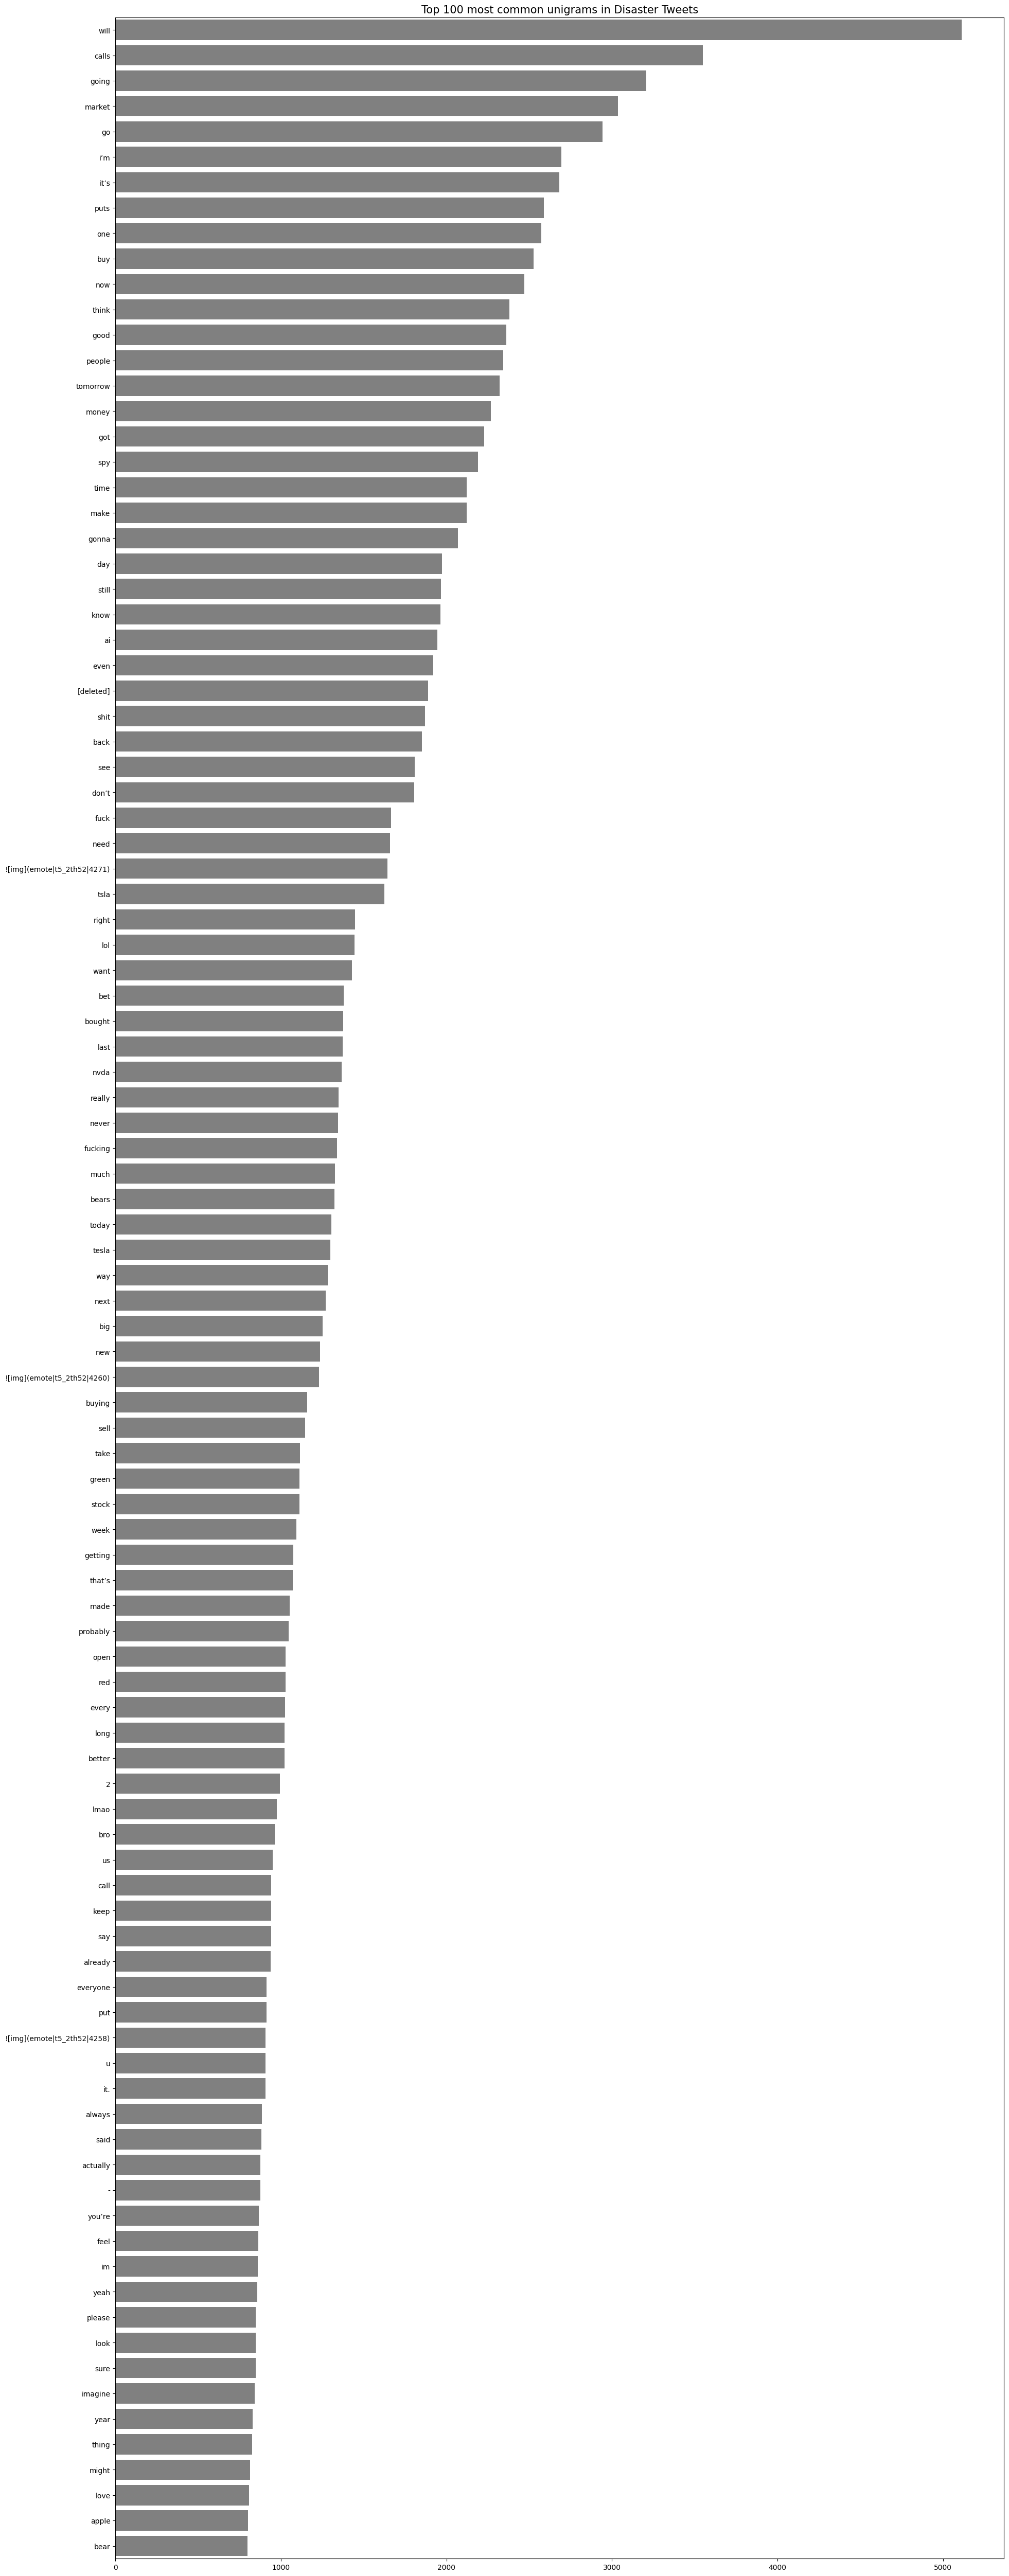

In [30]:
# visualisation for Unigrams
fig = plt.subplots(figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams[0].values[:N], x=df_unigrams[1].values[:N], color='gray')

plt.title(f'Top {N} most common unigrams in Comments', fontsize=15)

plt.show()

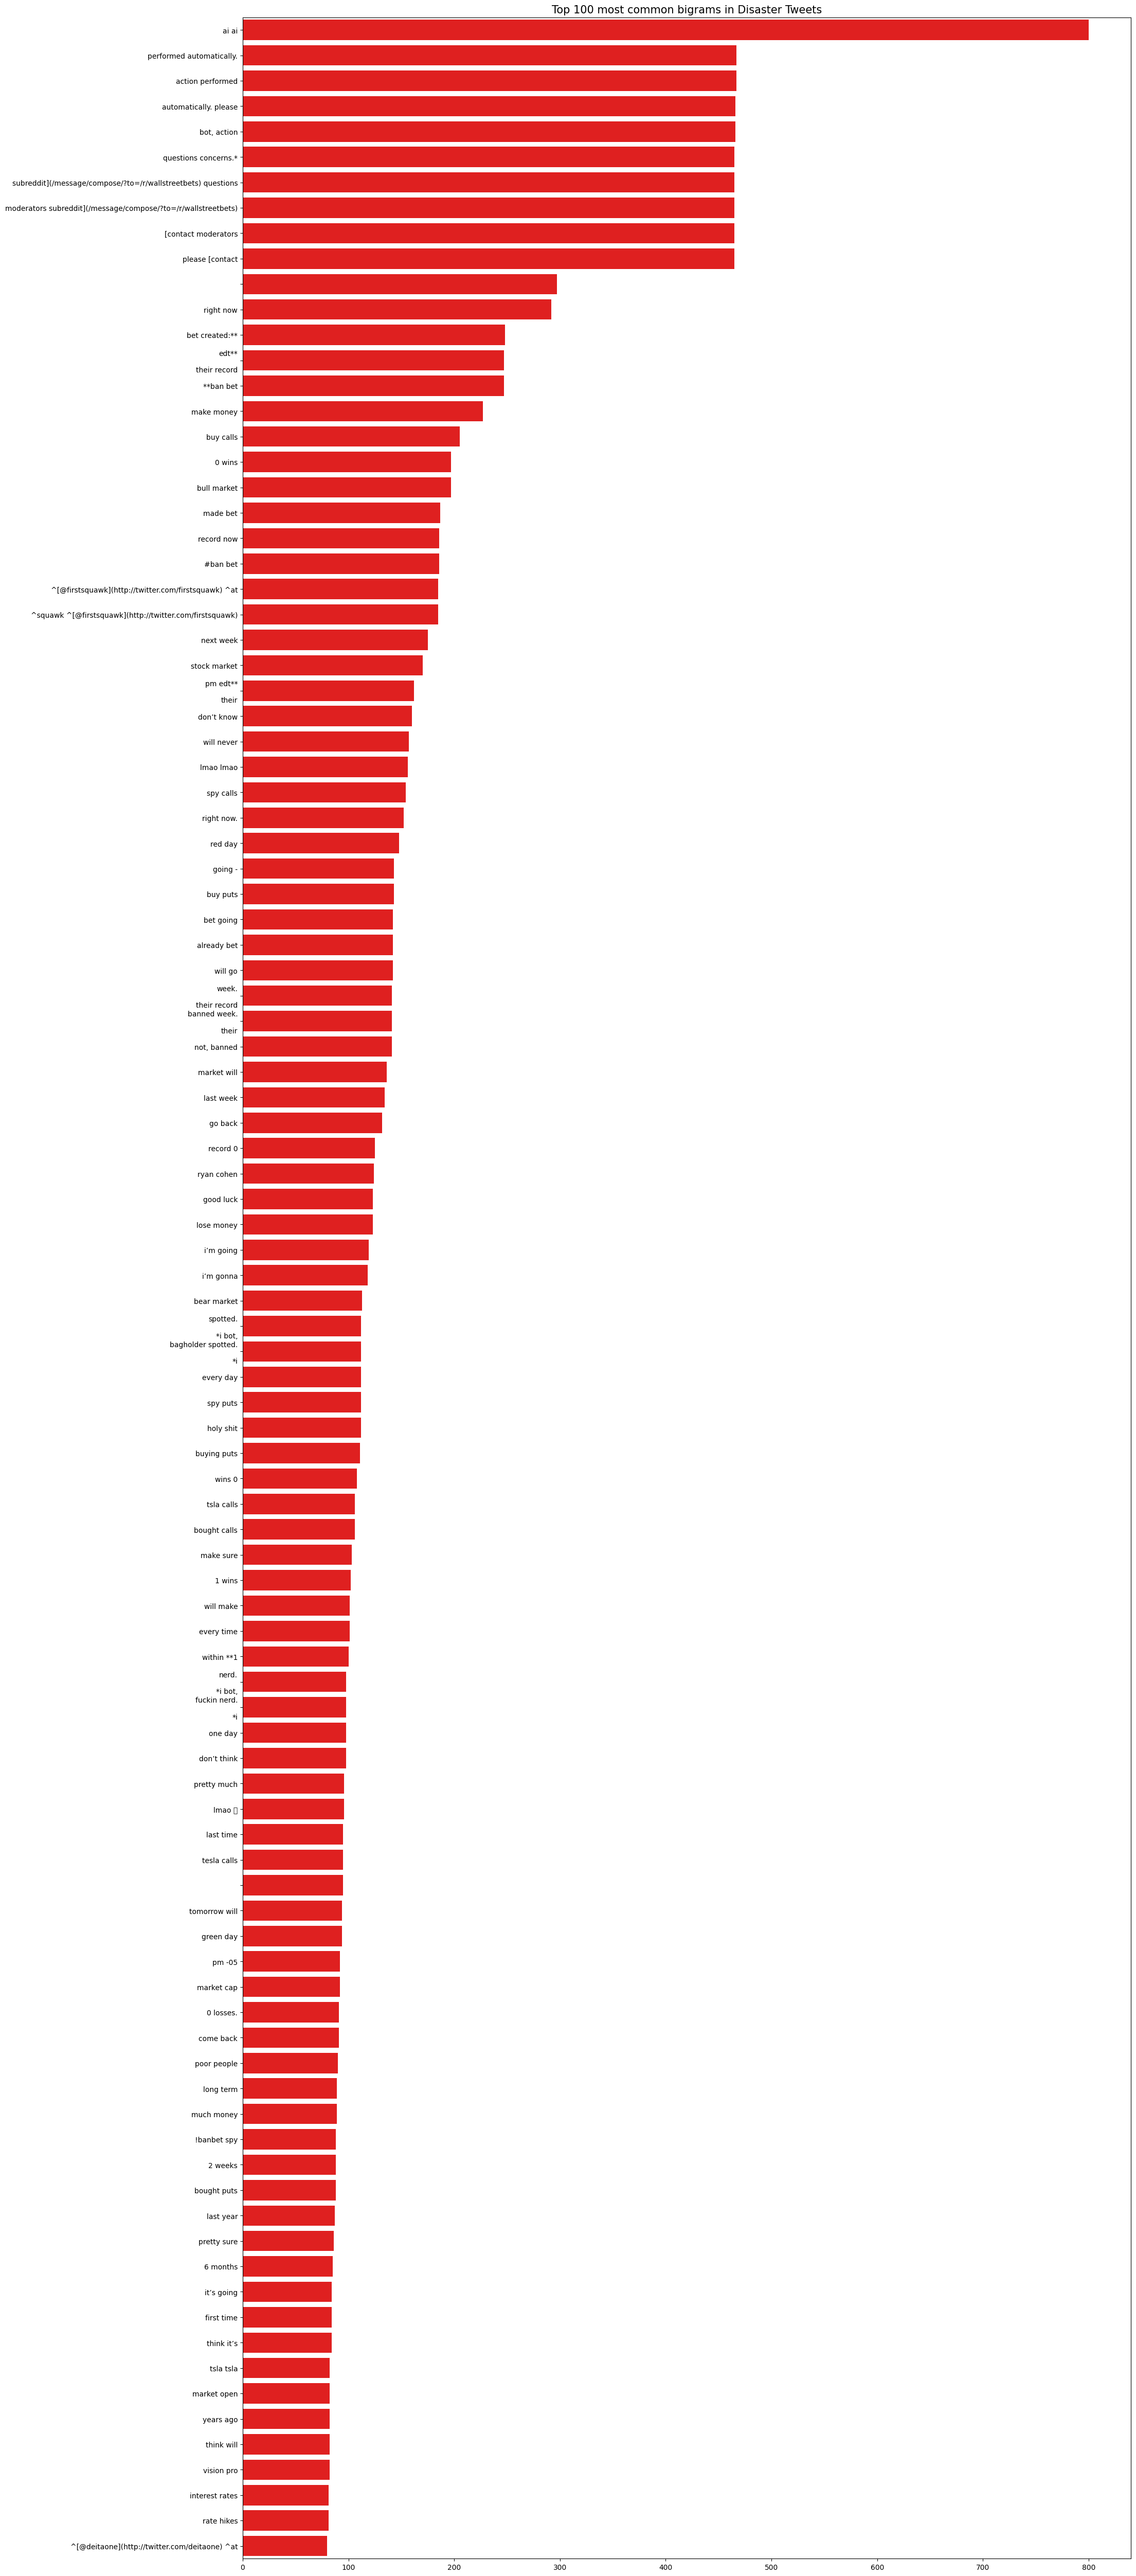

In [31]:
# visualisation of bigrams

fig = plt.subplots(figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_bigrams[0].values[:N], x=df_bigrams[1].values[:N], color='red')

plt.title(f'Top {N} most common bigrams in Comments', fontsize=15)

plt.show()

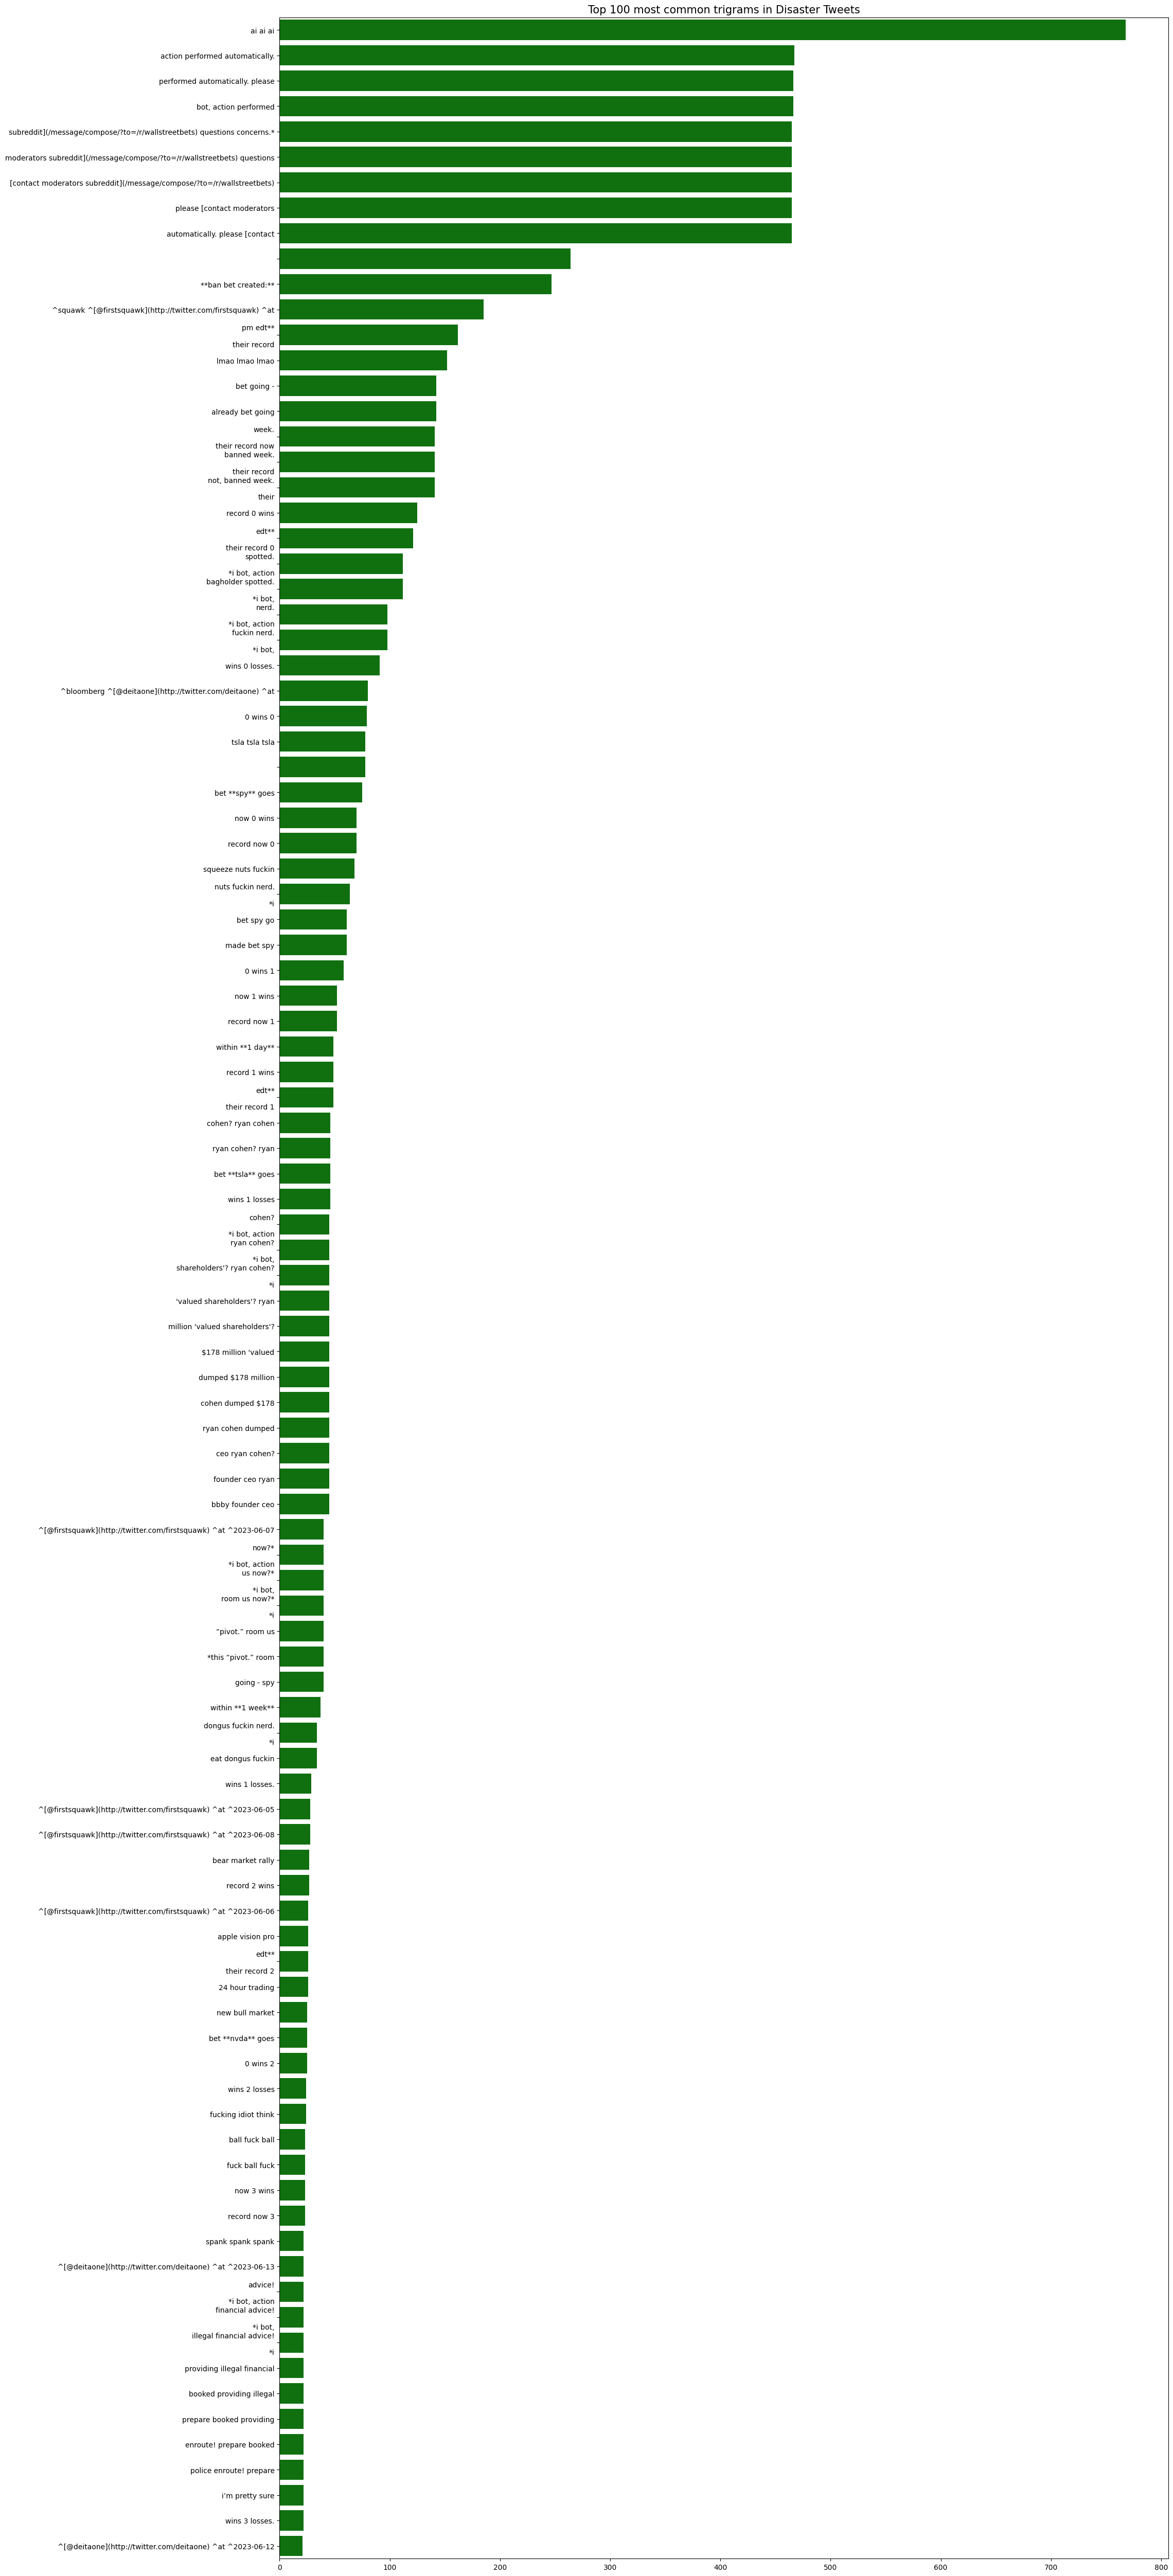

In [33]:
# visualisation of trigrams

fig = plt.subplots(figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_trigrams[0].values[:N], x=df_trigrams[1].values[:N], color='green')

plt.title(f'Top {N} most common trigrams in Comments', fontsize=15)

plt.show()

## 2. Data processing
1. clean the text with embedding (Glove/ Fasttext)


In [37]:
#Load the 2 popular embedding
#glove
#fasttext

# 讀取pickle文件
glove_embeddings = np.load('/content/drive/MyDrive/CUSCS - Group project/ML-NLP-Embeddings/crawl-300d-2M-002.pkl', allow_pickle=True)
fasttext_embeddings = np.load('/content/drive/MyDrive/CUSCS - Group project/ML-NLP-Embeddings/glove.840B.300d-001.pkl', allow_pickle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Embeddings Coverage

# break the comment into words
def build_vocab(X):

    comments = X.apply(lambda s: s.split()).values
    vocab = {}

    for cmt in comments:
        for word in cmt:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):

    vocab = build_vocab(X)

    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word] #函式嘗試將當前單詞加入到covered中，如果該單詞可以在embeddings中找到對應的向量
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word] # 否則，函式將當前單詞加入到oov中，表示該單詞未被涵蓋
            n_oov += vocab[word]

    #calculate the coverage
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))

    # 函式將oov字典按照值（即未涵蓋的單詞數量）進行排序，並以元祖列表的形式返回
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['comments'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Set'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['comments'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Set'.format(fasttext_vocab_coverage, fasttext_text_coverage))

GloVe Embeddings cover 48.02% of vocabulary and 89.00% of text in Set
FastText Embeddings cover 44.71% of vocabulary and 86.95% of text in Set


In [40]:
# read the oov and see how to further clean

# lump the 2 oov list as one
mergedlist = glove_oov + fasttext_oov

# 將新列表轉換為集合，這將刪除重複的元素
unique_set = set(mergedlist)

# 將集合轉換為列表，以便返回
total_oov = list(unique_set)
df_total_oov = pd.DataFrame(total_oov)

# save as new CSV
df_total_oov.to_csv('total_oov.csv')

print(f"The counts of records in Glove OOV list is {len(glove_oov)}")
print(f"The counts of records in Fasttest OOV list is {len(fasttext_oov)}")
print(f"The counts of records in Total OOV list is {len(total_oov)}")

The counts of records in Glove OOV list is 51472
The counts of records in Fasttest OOV list is 54759
The counts of records in Total OOV list is 56188


In [41]:
%%time

def clean(comment):

    # Special characters
    comment = re.sub(r"\x89Û_", "", comment)
    comment = re.sub(r"\x89ÛÒ", "", comment)
    comment = re.sub(r"\x89ÛÓ", "", comment)
    comment = re.sub(r"\x89ÛÏWhen", "When", comment)
    comment = re.sub(r"\x89ÛÏ", "", comment)
    comment = re.sub(r"China\x89Ûªs", "China's", comment)
    comment = re.sub(r"let\x89Ûªs", "let's", comment)
    comment = re.sub(r"\x89Û÷", "", comment)
    comment = re.sub(r"\x89Ûª", "", comment)
    comment = re.sub(r"\x89Û\x9d", "", comment)
    comment = re.sub(r"å_", "", comment)
    comment = re.sub(r"\x89Û¢", "", comment)
    comment = re.sub(r"\x89Û¢åÊ", "", comment)
    comment = re.sub(r"fromåÊwounds", "from wounds", comment)
    comment = re.sub(r"åÊ", "", comment)
    comment = re.sub(r"åÈ", "", comment)
    comment = re.sub(r"JapÌ_n", "Japan", comment)
    comment = re.sub(r"Ì©", "e", comment)
    comment = re.sub(r"å¨", "", comment)
    comment = re.sub(r"SuruÌ¤", "Suruc", comment)
    comment = re.sub(r"åÇ", "", comment)
    comment = re.sub(r"å£3million", "3 million", comment)
    comment = re.sub(r"åÀ", "", comment)

    # Contractions
    comment = re.sub(r"he's", "he is", comment)
    comment = re.sub(r"there's", "there is", comment)
    comment = re.sub(r"We're", "We are", comment)
    comment = re.sub(r"That's", "That is", comment)
    comment = re.sub(r"won't", "will not", comment)
    comment = re.sub(r"they're", "they are", comment)
    comment = re.sub(r"Can't", "Cannot", comment)
    comment = re.sub(r"wasn't", "was not", comment)
    comment = re.sub(r"don\x89Ûªt", "do not", comment)
    comment = re.sub(r"aren't", "are not", comment)
    comment = re.sub(r"isn't", "is not", comment)
    comment = re.sub(r"What's", "What is", comment)
    comment = re.sub(r"haven't", "have not", comment)
    comment = re.sub(r"hasn't", "has not", comment)
    comment = re.sub(r"There's", "There is", comment)
    comment = re.sub(r"He's", "He is", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"You're", "You are", comment)
    comment = re.sub(r"I'M", "I am", comment)
    comment = re.sub(r"shouldn't", "should not", comment)
    comment = re.sub(r"wouldn't", "would not", comment)
    comment = re.sub(r"i'm", "I am", comment)
    comment = re.sub(r"I\x89Ûªm", "I am", comment)
    comment = re.sub(r"I'm", "I am", comment)
    comment = re.sub(r"Isn't", "is not", comment)
    comment = re.sub(r"Here's", "Here is", comment)
    comment = re.sub(r"you've", "you have", comment)
    comment = re.sub(r"you\x89Ûªve", "you have", comment)
    comment = re.sub(r"we're", "we are", comment)
    comment = re.sub(r"what's", "what is", comment)
    comment = re.sub(r"couldn't", "could not", comment)
    comment = re.sub(r"we've", "we have", comment)
    comment = re.sub(r"it\x89Ûªs", "it is", comment)
    comment = re.sub(r"doesn\x89Ûªt", "does not", comment)
    comment = re.sub(r"It\x89Ûªs", "It is", comment)
    comment = re.sub(r"Here\x89Ûªs", "Here is", comment)
    comment = re.sub(r"who's", "who is", comment)
    comment = re.sub(r"I\x89Ûªve", "I have", comment)
    comment = re.sub(r"y'all", "you all", comment)
    comment = re.sub(r"can\x89Ûªt", "cannot", comment)
    comment = re.sub(r"would've", "would have", comment)
    comment = re.sub(r"it'll", "it will", comment)
    comment = re.sub(r"we'll", "we will", comment)
    comment = re.sub(r"wouldn\x89Ûªt", "would not", comment)
    comment = re.sub(r"We've", "We have", comment)
    comment = re.sub(r"he'll", "he will", comment)
    comment = re.sub(r"Y'all", "You all", comment)
    comment = re.sub(r"Weren't", "Were not", comment)
    comment = re.sub(r"Didn't", "Did not", comment)
    comment = re.sub(r"they'll", "they will", comment)
    comment = re.sub(r"they'd", "they would", comment)
    comment = re.sub(r"DON'T", "DO NOT", comment)
    comment = re.sub(r"That\x89Ûªs", "That is", comment)
    comment = re.sub(r"they've", "they have", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"should've", "should have", comment)
    comment = re.sub(r"You\x89Ûªre", "You are", comment)
    comment = re.sub(r"where's", "where is", comment)
    comment = re.sub(r"Don\x89Ûªt", "Do not", comment)
    comment = re.sub(r"we'd", "we would", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"weren't", "were not", comment)
    comment = re.sub(r"They're", "They are", comment)
    comment = re.sub(r"Can\x89Ûªt", "Cannot", comment)
    comment = re.sub(r"you\x89Ûªll", "you will", comment)
    comment = re.sub(r"I\x89Ûªd", "I would", comment)
    comment = re.sub(r"let's", "let us", comment)
    comment = re.sub(r"it's", "it is", comment)
    comment = re.sub(r"can't", "cannot", comment)
    comment = re.sub(r"don't", "do not", comment)
    comment = re.sub(r"you're", "you are", comment)
    comment = re.sub(r"i've", "I have", comment)
    comment = re.sub(r"that's", "that is", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"doesn't", "does not", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"didn't", "did not", comment)
    comment = re.sub(r"ain't", "am not", comment)
    comment = re.sub(r"you'll", "you will", comment)
    comment = re.sub(r"I've", "I have", comment)
    comment = re.sub(r"Don't", "do not", comment)
    comment = re.sub(r"I'll", "I will", comment)
    comment = re.sub(r"I'd", "I would", comment)
    comment = re.sub(r"Let's", "Let us", comment)
    comment = re.sub(r"you'd", "You would", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"Ain't", "am not", comment)
    comment = re.sub(r"Haven't", "Have not", comment)
    comment = re.sub(r"Could've", "Could have", comment)
    comment = re.sub(r"youve", "you have", comment)
    comment = re.sub(r"donå«t", "do not", comment)

    # Character entity references
    comment = re.sub(r"&gt;", ">", comment)
    comment = re.sub(r"&lt;", "<", comment)
    comment = re.sub(r"&amp;", "&", comment)

    # Typos, slang and informal abbreviations
    comment = re.sub(r"w/e", "whatever", comment)
    comment = re.sub(r"w/", "with", comment)
    comment = re.sub(r"USAgov", "USA government", comment)
    comment = re.sub(r"recentlu", "recently", comment)
    comment = re.sub(r"Ph0tos", "Photos", comment)
    comment = re.sub(r"amirite", "am I right", comment)
    comment = re.sub(r"exp0sed", "exposed", comment)
    comment = re.sub(r"<3", "love", comment)
    comment = re.sub(r"amageddon", "armageddon", comment)
    comment = re.sub(r"Trfc", "Traffic", comment)
    comment = re.sub(r"8/5/2015", "2015-08-05", comment)
    comment = re.sub(r"WindStorm", "Wind Storm", comment)
    comment = re.sub(r"8/6/2015", "2015-08-06", comment)
    comment = re.sub(r"10:38PM", "10:38 PM", comment)
    comment = re.sub(r"10:30pm", "10:30 PM", comment)
    comment = re.sub(r"16yr", "16 year", comment)
    comment = re.sub(r"lmao", "laughing my ass off", comment)
    comment = re.sub(r"TRAUMATISED", "traumatized", comment)

    # Urls
    comment = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", comment)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        comment = comment.replace(p, f' {p} ')

    # ... and ..
    comment = comment.replace('...', ' ... ')
    if '...' not in comment:
        comment = comment.replace('..', ' ... ')

    # Acronyms
    comment = re.sub(r"MH370", "Malaysia Airlines Flight 370", comment)
    comment = re.sub(r"mÌ¼sica", "music", comment)
    comment = re.sub(r"okwx", "Oklahoma City Weather", comment)
    comment = re.sub(r"arwx", "Arkansas Weather", comment)
    comment = re.sub(r"gawx", "Georgia Weather", comment)
    comment = re.sub(r"scwx", "South Carolina Weather", comment)
    comment = re.sub(r"cawx", "California Weather", comment)
    comment = re.sub(r"tnwx", "Tennessee Weather", comment)
    comment = re.sub(r"azwx", "Arizona Weather", comment)
    comment = re.sub(r"alwx", "Alabama Weather", comment)
    comment = re.sub(r"wordpressdotcom", "wordpress", comment)
    comment = re.sub(r"usNWSgov", "United States National Weather Service", comment)
    comment = re.sub(r"Suruc", "Sanliurfa", comment)

    # Grouping same words without embeddings
    comment = re.sub(r"Bestnaijamade", "bestnaijamade", comment)
    comment = re.sub(r"SOUDELOR", "Soudelor", comment)

    return comment

consol_df['comments_cleaned'] = consol_df['comments'].apply(lambda s : clean(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['comments_cleaned'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['comments_cleaned'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(fasttext_vocab_coverage, fasttext_text_coverage))

GloVe Embeddings cover 65.39% of vocabulary and 94.69% of text in Training Set
FastText Embeddings cover 65.04% of vocabulary and 94.01% of text in Training Set
CPU times: user 5.98 s, sys: 0 ns, total: 5.98 s
Wall time: 6.49 s


In [43]:
consol_df.to_csv('consol_df.csv')

In [ ]:
# After cleaning, glove_embeddings and fasttext_embeddings are deleted and garbage collected because they consume too much memory (10+ gigabytes).
del glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,
gc.collect()

In [44]:
# cleaned
# Unigrams
consol_unigrams_cleaned = defaultdict(int)

for cmt in consol_df['comments_cleaned']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned[word] += 1

df_unigrams_cleaned = pd.DataFrame(sorted(consol_unigrams_cleaned.items(), key=lambda x: x[1])[::-1])

# Bigrams
consol_bigrams_cleaned = defaultdict(int)

for cmt in consol_df['comments_cleaned']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned[word] += 1

df_bigrams_cleaned = pd.DataFrame(sorted(consol_bigrams_cleaned.items(), key=lambda x: x[1])[::-1])

# Trigrams
consol_trigrams_cleaned = defaultdict(int)

for cmt in consol_df['comments_cleaned']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned[word] += 1

df_trigrams_cleaned = pd.DataFrame(sorted(consol_trigrams_cleaned.items(), key=lambda x: x[1])[::-1])

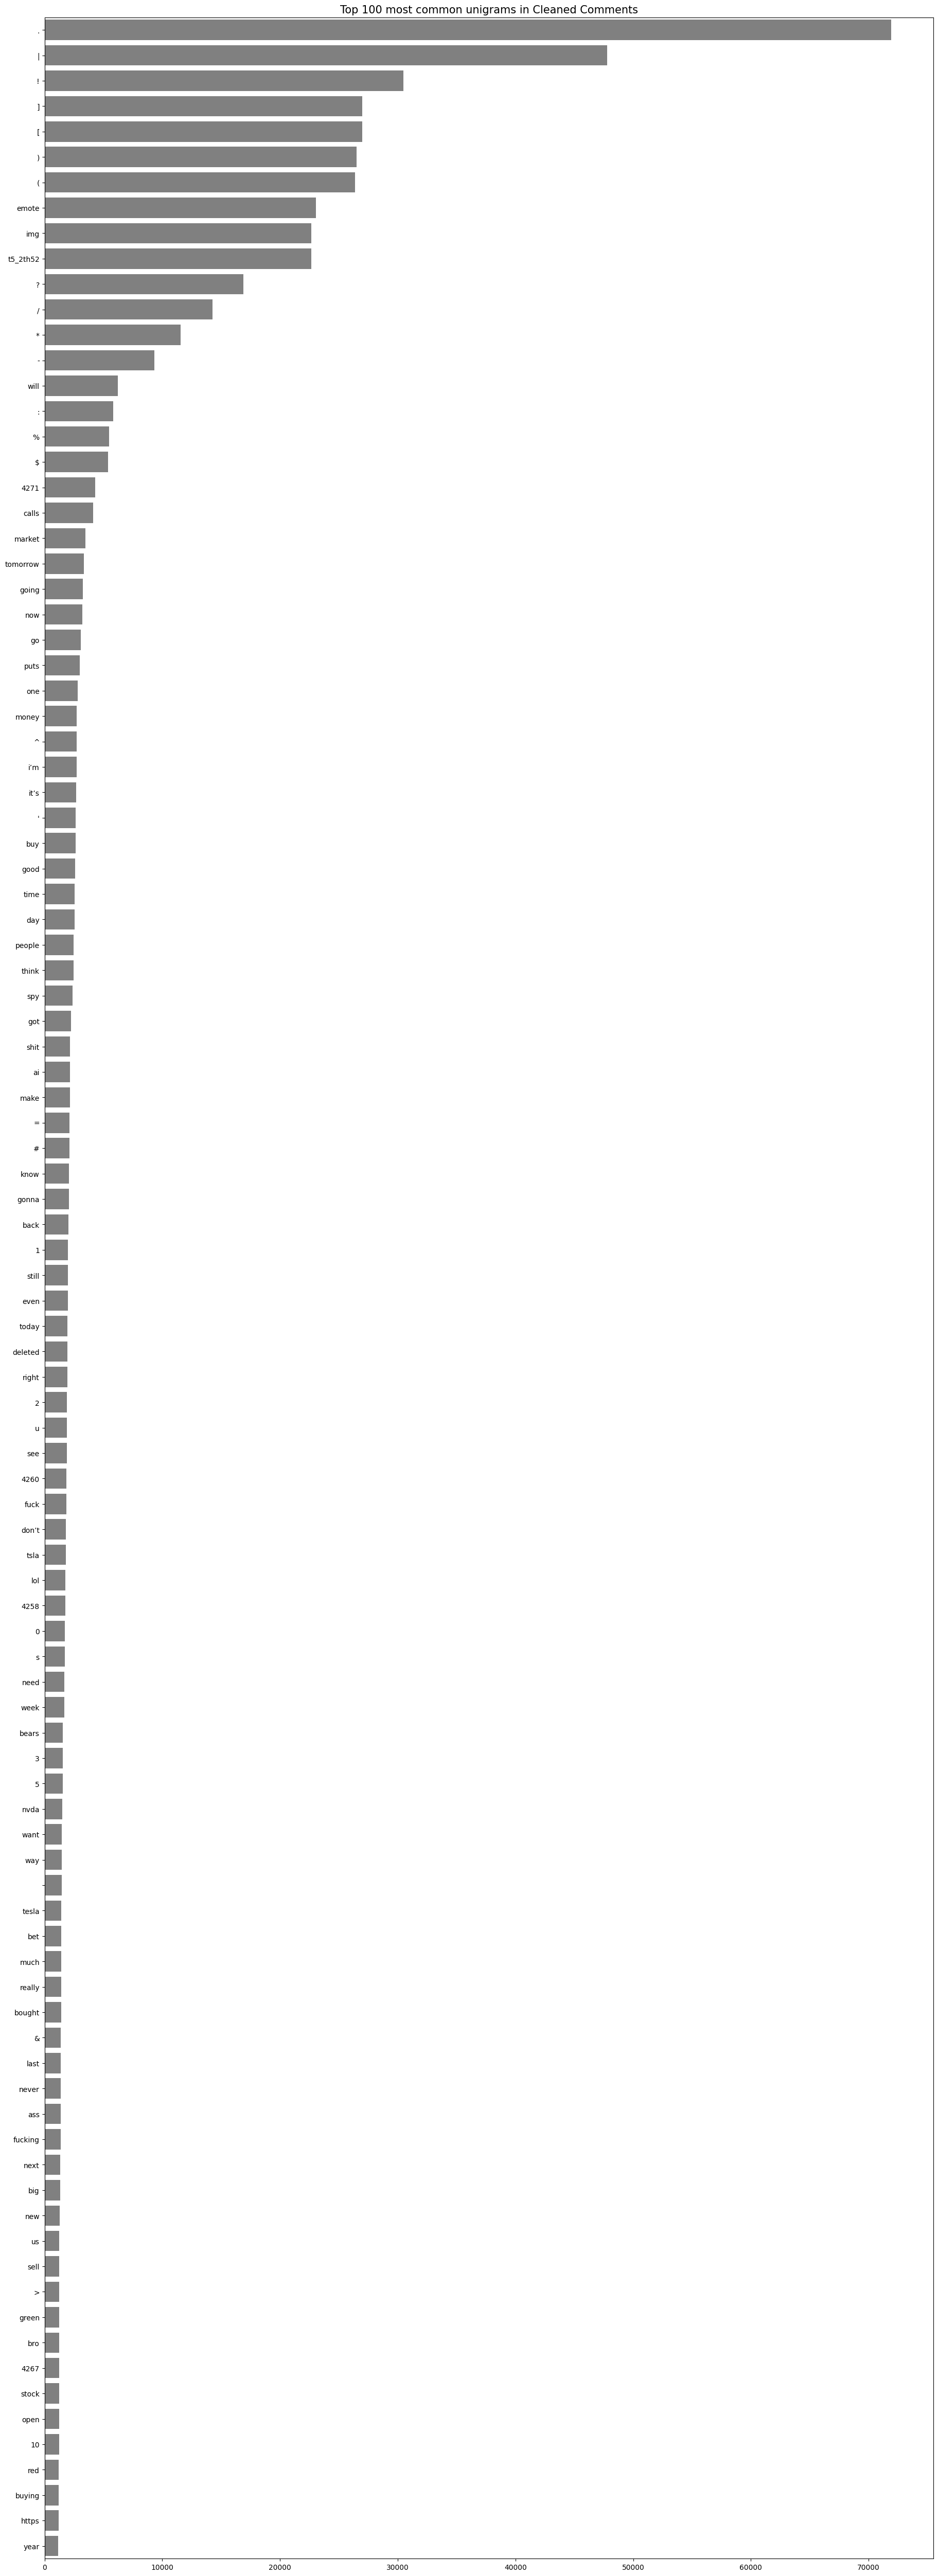

In [45]:
# visualisation for Unigrams
fig = plt.subplots(figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned[0].values[:N], x=df_unigrams_cleaned[1].values[:N], color='gray')

plt.title(f'Top {N} most common unigrams in Cleaned Comments', fontsize=15)

plt.show()

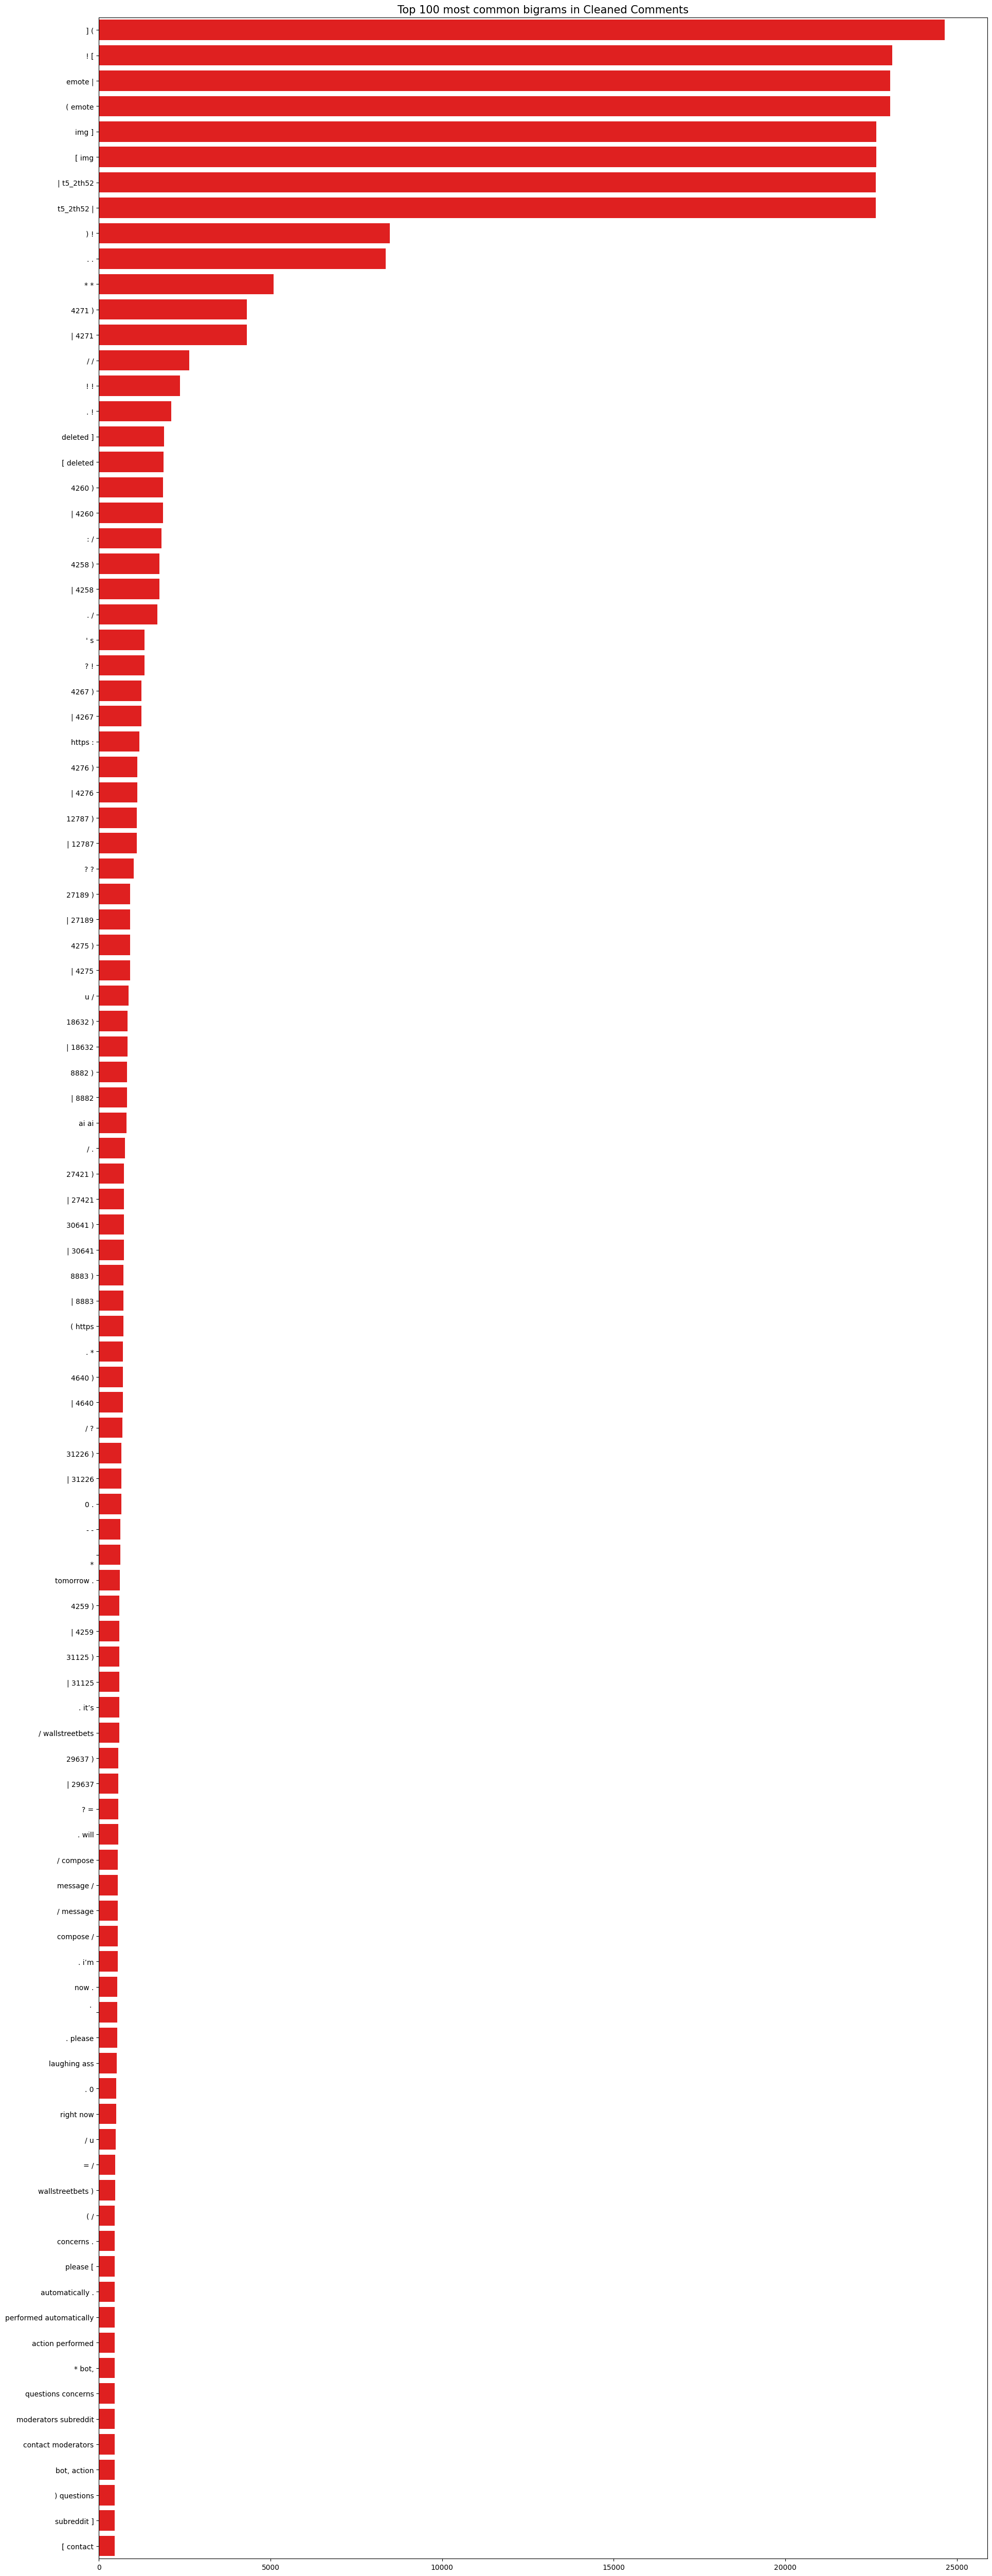

In [46]:
# visualisation of bigrams

fig = plt.subplots(figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_bigrams_cleaned[0].values[:N], x=df_bigrams_cleaned[1].values[:N], color='red')

plt.title(f'Top {N} most common bigrams in Cleaned Comments', fontsize=15)

plt.show()

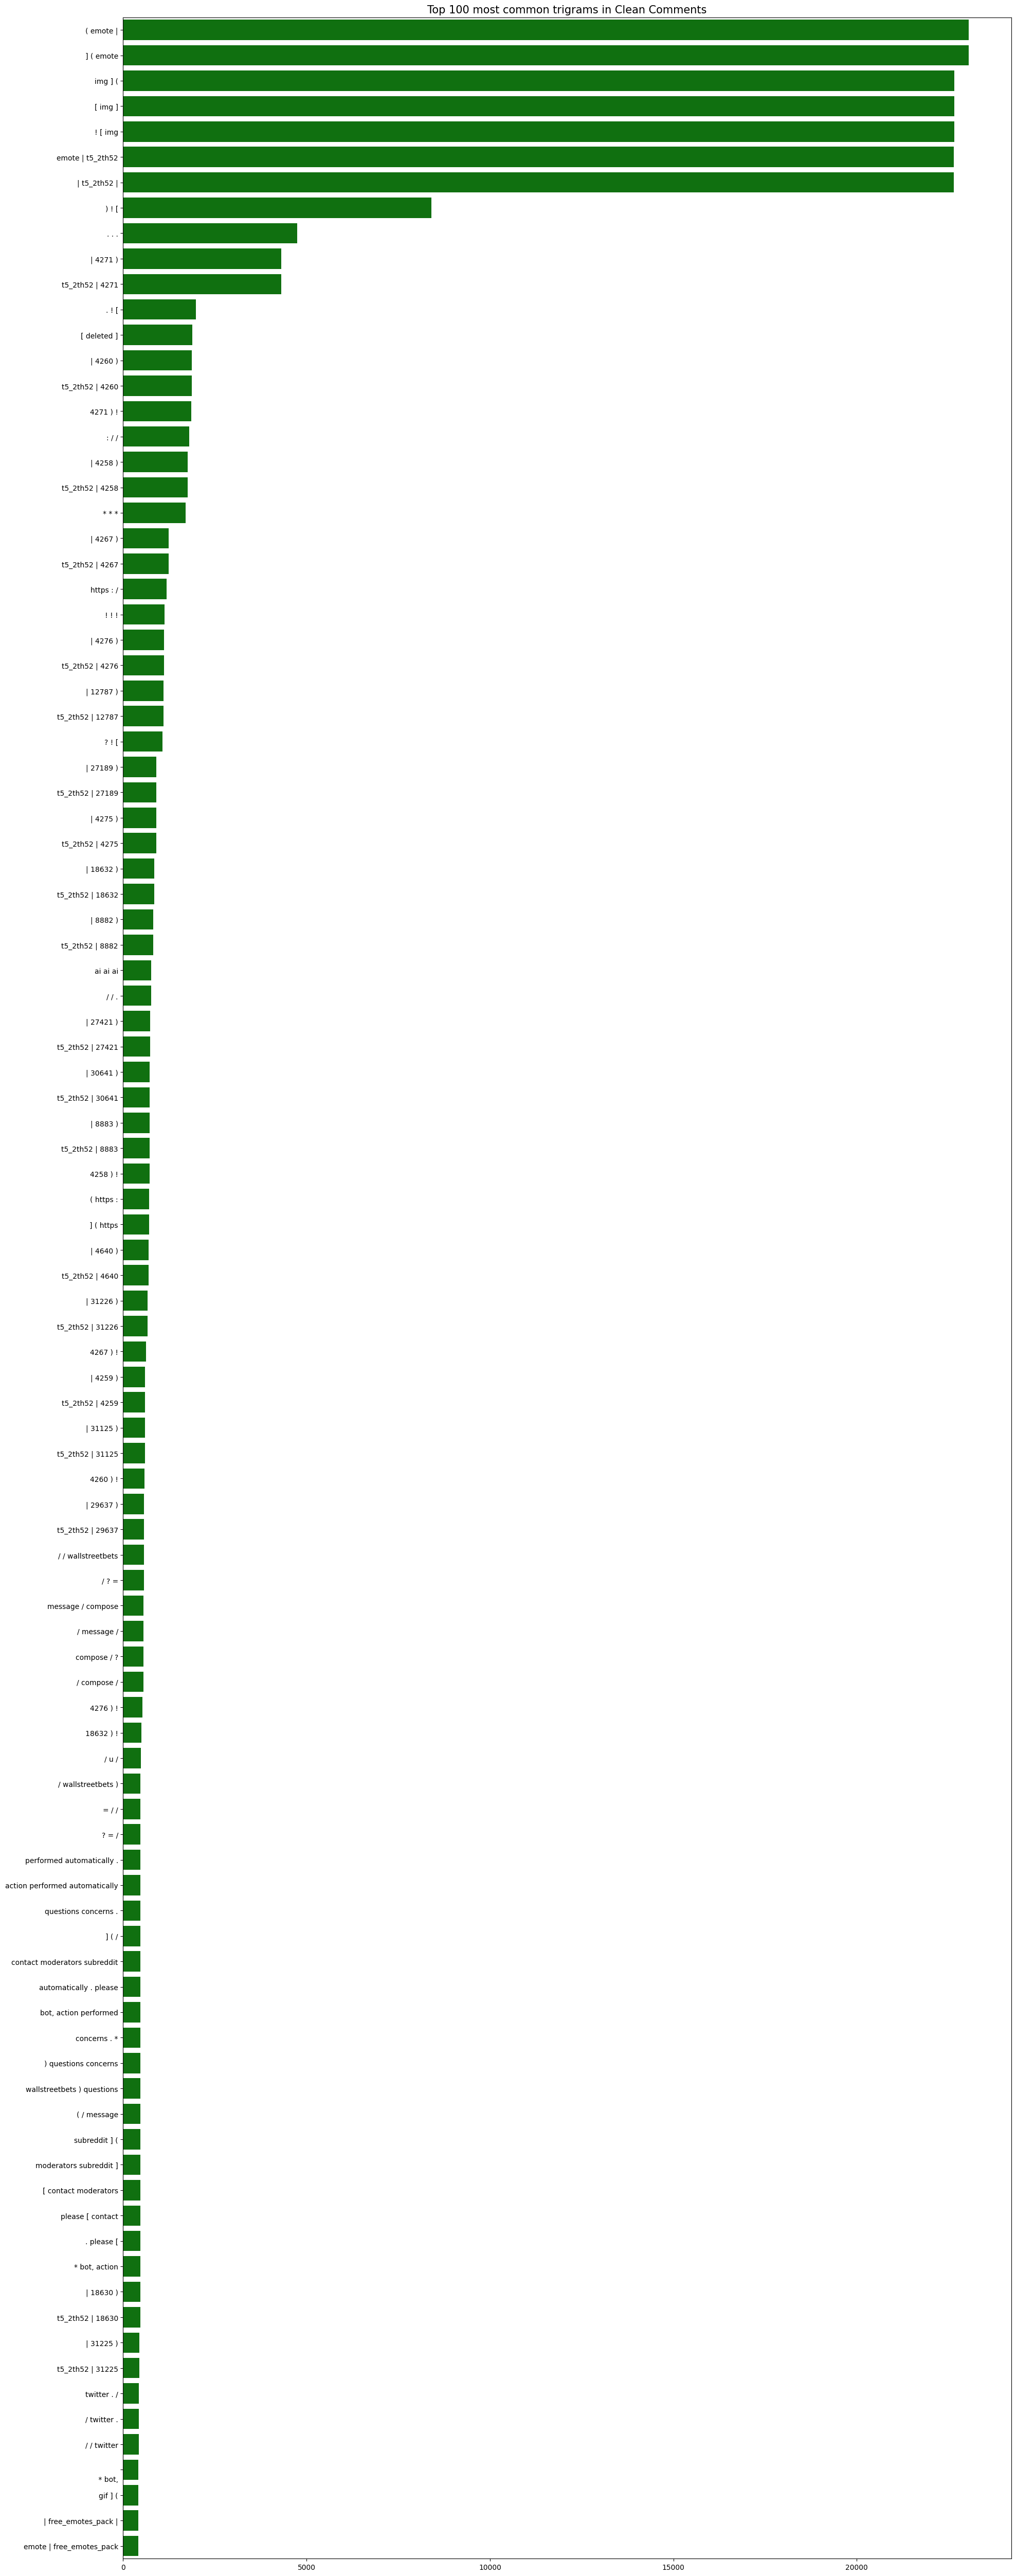

In [47]:
# visualisation of trigrams

fig = plt.subplots(figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_trigrams_cleaned[0].values[:N], x=df_trigrams_cleaned[1].values[:N], color='green')

plt.title(f'Top {N} most common trigrams in Clean Comments', fontsize=15)

plt.show()

Duplicated labeled records

In [ ]:
# extract the list of "text"
df_mislabeled = consol_df.groupby(['comments']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

In [ ]:
# review and relabel the text one by one

what if the keyword is new and never trained before in model?

In [ ]:
# Scikit-learn庫中的StratifiedKFold類別，它可以將資料集分為K個互斥的子集，以便進行交叉驗證
# 為了確保每個子集都能夠代表整個資料集的類別分佈
K = 3
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = train_df['target'] == 1
print('Whole Training Set Shape = {}'.format(train_df.shape))
print('Whole Training Set Unique keyword Count = {}'.format(train_df['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(train_df[DISASTER]['target_relabeled'].count(), train_df[~DISASTER]['target_relabeled'].count()))

#在每個子集的迭代中，程式碼選擇訓練集和驗證集中文本數據的子集，然後使用shape屬性顯示它們的形狀。這將顯示訓練集中有多少行和列，以及驗證集中有多少行和列
# 接下來，計算訓練集和驗證集中關鍵字的唯一數量, 了解訓練集和驗證集之間的關鍵字分佈是否相似，進而確定模型是否過度擬合
# 每次迭代都會得到一個訓練集和一個驗證集的索引，這些索引可以用來從原始數據集中選擇相應的樣本進行訓練和驗證
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df['text_cleaned'], train_df['target']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_df.loc[trn_idx, 'text_cleaned'].shape, train_df.loc[val_idx, 'text_cleaned'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, train_df.loc[trn_idx, 'keyword'].nunique(), train_df.loc[val_idx, 'keyword'].nunique()))

In [ ]:
# training dataset
# single key word
# bi-gram
# tri-gram